<a href="https://colab.research.google.com/github/amadousysada/image-segmentation/blob/main/p8_01_exploration_and_features_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Import des librairies

In [2]:
import time
init_time = time.time()

import os

import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


# MLFLOW
!pip install mlflow==2.22.0 -q
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

print("Versions:")
print(f"{' '*2}- Numpy        =>: {np.__version__}")
print(f"{' '*2}- tensorflow   =>: {tf.__version__}")
print(f"{' '*2}- keras        =>: {tf.keras.__version__}")
print(f"{' '*2}- matplotlib   =>: {plt.matplotlib.__version__}")
print(f"{' '*2}- mlflow   =>: {mlflow.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 127.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.6/680.6 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.5 MB/s eta 0:00:00
Versions:
  - Numpy        =>: 2.0.2
  - 

In [3]:
base_path = "/content/drive/MyDrive/data/"
image_dir = os.path.join(base_path, "leftImg8bit")
mask_dir = os.path.join(base_path, "gtFine")

MLFLOW_TRACKING_URI = "https://mlflow.amadousy.dev"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploration

In [5]:
# Mapping des groupes vers la liste des classes Cityscapes correspondantes
"""
Sources:
  - https://raw.githubusercontent.com/mcordts/cityscapesScripts/master/cityscapesscripts/helpers/labels.py
  - https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
  - https://datasetninja.com/cityscapes
  - https://github.com/mcordts/cityscapesScripts
"""
CLASS_GROUPS = {
    "flat":        ["road", "sidewalk", "parking", "rail track"],
    "human":       ["person", "rider"],
    "vehicle":     ["car", "truck", "bus", "on rails", "motorcycle", "bicycle", "caravan", "trailer"],
    "construction":["building", "wall", "fence", "guard rail", "bridge", "tunnel"],
    "object":      ["pole", "pole group", "traffic sign", "traffic light"],
    "nature":      ["vegetation", "terrain"],
    "sky":         ["sky"],
    "void":        ["unlabeled", "ego vehicle", "ground", "rectification border", "out of roi", "dynamic", "static"]
}

GROUP_PALETTE = [
    (128, 64, 128),    # 0 - flat
    (220, 20, 60),     # 1 - human
    (0, 0, 142),       # 2 - vehicle
    (70, 70, 70),      # 3 - construction
    (220, 220, 0),     # 4 - object
    (107, 142, 35),    # 5 - nature
    (70, 130, 180),    # 6 - sky
    (0, 0, 0),         # 7 - void
]

group_cmap = ListedColormap(np.array(GROUP_PALETTE) / 255.0)

ordered_groups = list(CLASS_GROUPS.keys())

LABEL_ID_TO_NAME = {
    0: "unlabeled",
    1: "ego vehicle",
    2: "rectification border",
    3: "out of roi",
    4: "static",
    5: "dynamic",
    6: "ground",
    7: "road",
    8: "sidewalk",
    9: "parking",
    10: "rail track",
    11: "building",
    12: "wall",
    13: "fence",
    14: "guard rail",
    15: "bridge",
    16: "tunnel",
    17: "pole",
    18: "pole group",
    19: "traffic light",
    20: "traffic sign",
    21: "vegetation",
    22: "terrain",
    23: "sky",
    24: "person",
    25: "rider",
    26: "car",
    27: "truck",
    28: "bus",
    29: "caravan",
    30: "trailer",
    31: "on rails",
    32: "motorcycle",
    33: "bicycle",
}

NAME_TO_LABEL_ID = {v: k for k, v in sorted(LABEL_ID_TO_NAME.items())}

CLASS_MAP = {}
for group_idx, group_name in enumerate(ordered_groups):
    for class_name in CLASS_GROUPS[group_name]:
        cid = NAME_TO_LABEL_ID.get(class_name, -1)
        CLASS_MAP[cid] = group_idx


mapping = [7] * 34   # initialisé à 7 (void)
for orig_id, new_id in CLASS_MAP.items():
    mapping[orig_id] = new_id

In [6]:
tf.constant(mapping, dtype=tf.int32)

<tf.Tensor: shape=(34,), dtype=int32, numpy=
array([7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5,
       5, 6, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)>

In [7]:
def augment_data(image, mask):
    # flip horizontal aléatoire
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask  = tf.image.flip_left_right(mask[..., tf.newaxis])[..., 0]
    # légère variation de contraste
    image = tf.image.random_contrast(image, 0.8, 1.2)
    # légère variation de luminosité
    image = tf.image.random_brightness(image, 0.1)
    return image, mask


def build_dataset(img_paths, mask_paths, image_size=(224, 224), data_type="train", batch_size=32, validation_split=0.3, augment=False, shuffle=False):
  ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))

  def _load(i, m):
    img = tf.image.decode_png(tf.io.read_file(i), channels=3)
    mask = tf.image.decode_png(tf.io.read_file(m), channels=1)
    img = tf.image.resize(img, image_size, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.image.resize(mask, image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.int32)

    mask = tf.gather(tf.constant(mapping, dtype=tf.int32), mask)

    return img, mask

  ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(buffer_size=1024)

  if augment:
    ds = ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

  ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return ds

def make_dataset(image_size=(224, 224), data_type="train", batch_size=32, validation_split=0.0, augment=False, shuffle=False):
  images_path = []
  masks_path = []

  for city in os.listdir(f"{image_dir}/{data_type}"):
    image_path = os.path.join(image_dir, data_type, city)
    mask_path = os.path.join(mask_dir, data_type, city)
    for image in os.listdir(image_path):
      if image.endswith("_leftImg8bit.png"):
        base = image.replace("_leftImg8bit.png", "")
        mask = base + "_gtFine_labelIds.png"
        if os.path.exists(os.path.join(mask_path, mask)):
          images_path.append(os.path.join(image_path, image))
          masks_path.append(os.path.join(mask_path, mask))

  if data_type == "train" and validation_split > 0:
      n = len(images_path)
      split_idx = int((1 - validation_split) * n)
      train_imgs, val_imgs = images_path[:split_idx], images_path[split_idx:]
      train_msks, val_msks = masks_path[:split_idx], masks_path[split_idx:]

      train_ds = build_dataset(train_imgs, train_msks, image_size, batch_size, shuffle=shuffle, augment=augment)
      val_ds   = build_dataset(val_imgs, val_msks, image_size, batch_size)
      return train_ds, val_ds
  else:
      return build_dataset(images_path, masks_path, image_size, batch_size, shuffle=shuffle, augment=augment)

In [8]:
def show_vertical_legend(palette, labels, ax):
    """
    Affiche une légende verticale (groupe/couleur).
    palette : liste de couleurs RGB [(R,G,B), ...]
    labels : liste des noms de groupes (même taille que palette)
    """
    # Créer les patches (légendes)
    patches = [
        mpatches.Patch(color=np.array(rgb)/255.0, label=label)
        for rgb, label in zip(palette, labels)
    ]

    # Afficher la légende verticalement à gauche
    ax.legend(handles=patches, loc='center left', bbox_to_anchor=(0, 0.5),
              frameon=False, fontsize=10)
    ax.axis('off')
    plt.tight_layout()

def plot_sample(ds, figsize=(14, 6), title=""):
  for imgs, masks in ds.take(1):
    idx = np.random.choice(range(0,32))
    img = imgs[idx]
    mask = masks[idx]

    plt.figure(figsize=figsize)
    ax= plt.subplot(1, 4, 1)
    ax.imshow(img)
    plt.title("Image")
    plt.axis("off")

    ax = plt.subplot(1, 4, 2)
    ax.imshow(mask, cmap=group_cmap, interpolation='nearest', vmin=0, vmax=len(GROUP_PALETTE)-1)
    plt.title("Mask")
    plt.axis("off")

    ax = plt.subplot(1, 4, 3)
    mask_arr = mask.numpy()
    unique_classes, counts = np.unique(mask_arr, return_counts=True)
    percentages = counts / mask_arr.size * 100
    group_names = [ordered_groups[i] for i in unique_classes]

    ax.pie(percentages, labels=group_names, autopct="%1.1f%%", startangle=90, colors=group_cmap.colors, textprops={'color': 'white'})
    ax.axis("equal")
    ax.set_title("Répartition des groupes dans le mask")
    plt.axis("equal")
    plt.suptitle("Test de l'echantillon train", fontsize=16)

    ax = plt.subplot(1, 4, 4)
    show_vertical_legend(GROUP_PALETTE, ordered_groups, ax)
    plt.show()


def display_prediction(image, pred_mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap=group_cmap, interpolation='nearest', vmin=0, vmax=len(GROUP_PALETTE)-1)  # tu peux aussi utiliser une palette custom
    plt.title("Prédiction (groupes)")
    plt.axis("off")

    ax = plt.subplot(1, 3, 3)
    show_vertical_legend(GROUP_PALETTE, ordered_groups, ax)

    plt.show()

In [9]:
%%time
train_ds = make_dataset(data_type="train", batch_size=32, augment=True)
validation_ds = make_dataset(data_type="val", batch_size=32)
test_ds = make_dataset(data_type="test", batch_size=32)

CPU times: user 375 ms, sys: 182 ms, total: 556 ms
Wall time: 31.2 s


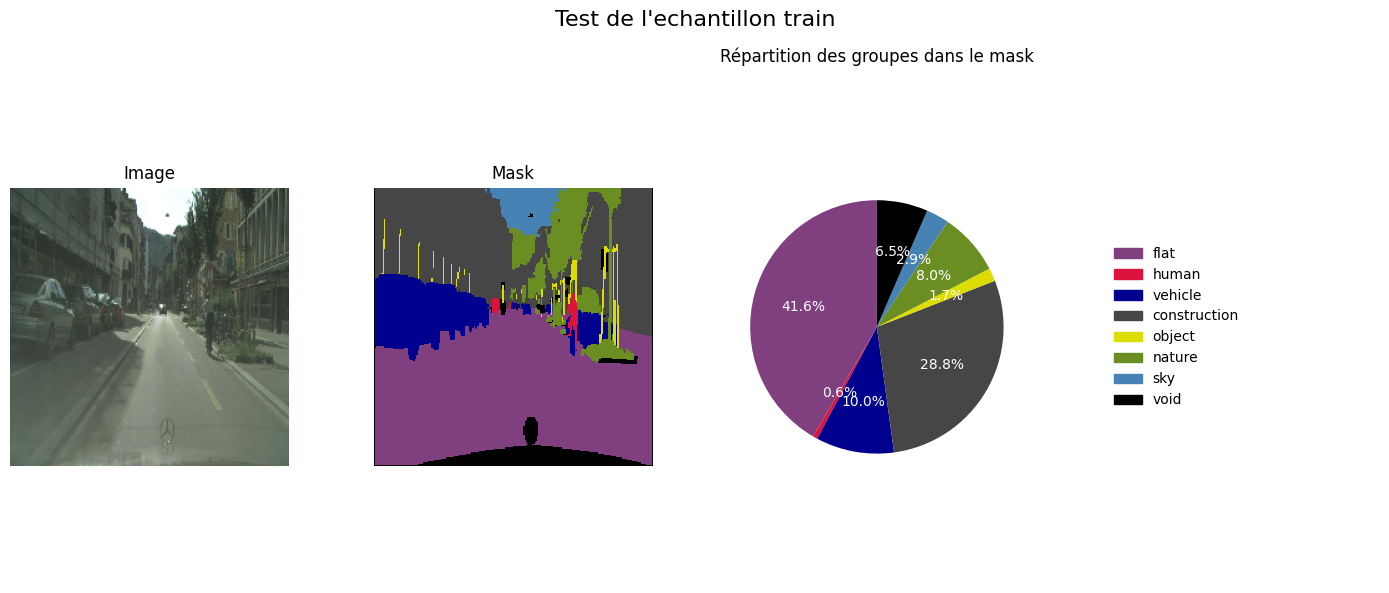

CPU times: user 3.53 s, sys: 182 ms, total: 3.71 s
Wall time: 4.85 s


In [10]:
%%time
plot_sample(train_ds, title="Test de l'echantillon train")

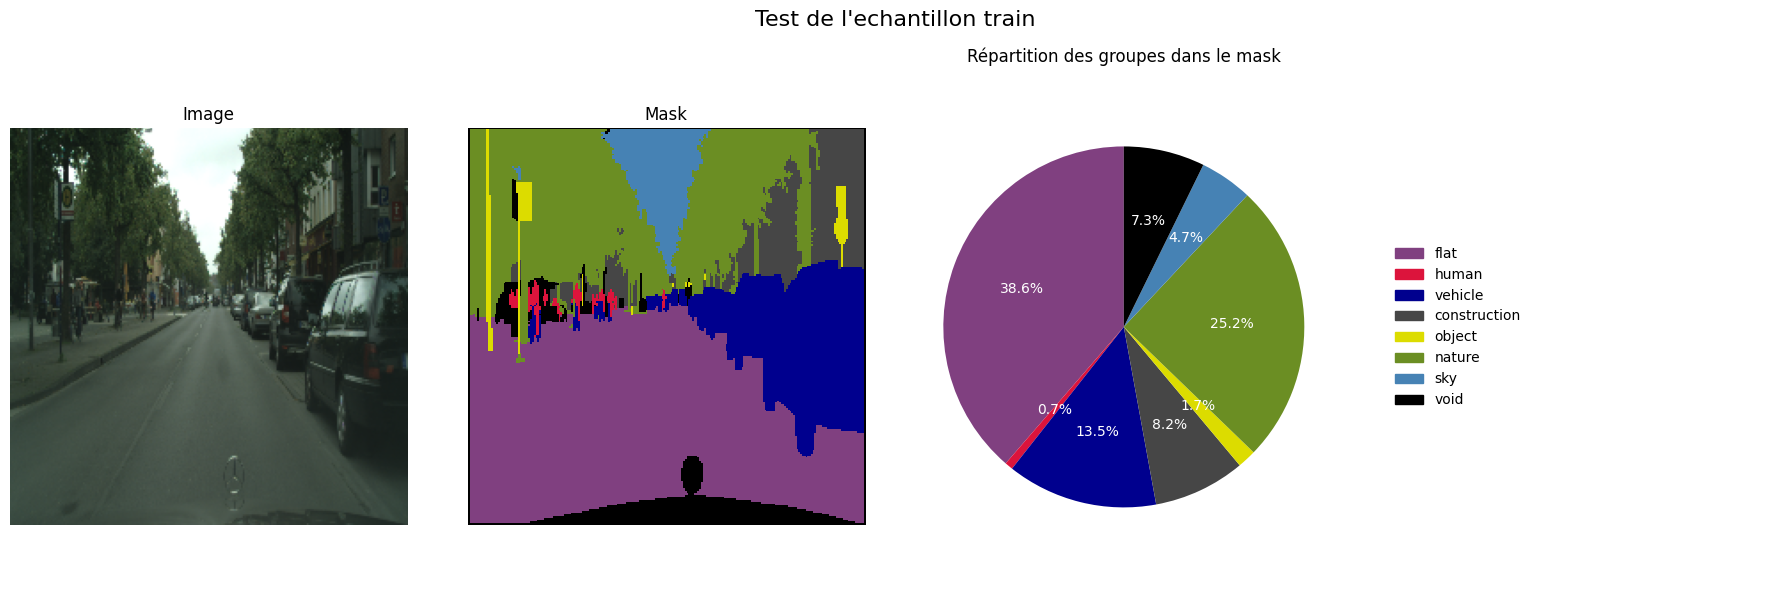

CPU times: user 4.03 s, sys: 108 ms, total: 4.14 s
Wall time: 6.23 s


In [11]:
%%time
plot_sample(validation_ds, title="Test de l'echantillon validation", figsize=(18, 6))

AFFICHER LES LABELS par COULEURS

# Modélisation

### Metrics & Loss functions

**Metrcis**:
* MeanIoU
* Accuracy

In [12]:
class MeanIoUArgmax(tf.keras.metrics.MeanIoU):
    """Custom MeanIoU metric that applies argmax to predictions"""
    def __init__(self, num_classes, name="mean_io_u_argmax", **kwargs):
        super().__init__(num_classes=num_classes, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_pred : (batch, H, W, num_classes) → take the winning class
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)



**Loss functions:**
* Dice Loss
* Focal Loss
* Combined Loss
* balanced_cross_entropy

In [13]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice Loss for semantic segmentation

    Args:
        y_true: Ground truth masks (batch_size, H, W)
        y_pred: Predicted logits (batch_size, H, W, num_classes)
        smooth: Smoothing factor to avoid division by zero

    Returns:
        Dice loss value
    """
    # Convert predictions to probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Convert ground truth to one-hot encoding
    num_classes = tf.shape(y_pred)[-1]
    y_true = tf.cast(y_true, tf.int32)
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

    # Flatten tensors
    y_true_flat = tf.reshape(y_true_one_hot, [-1, num_classes])
    y_pred_flat = tf.reshape(y_pred, [-1, num_classes])

    # Calculate Dice coefficient for each class
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
    union = tf.reduce_sum(y_true_flat, axis=0) + tf.reduce_sum(y_pred_flat, axis=0)

    dice_coeff = (2. * intersection + smooth) / (union + smooth)

    # Return 1 - mean Dice coefficient as loss
    return 1 - tf.reduce_mean(dice_coeff)


def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """
    Focal Loss for addressing class imbalance

    Args:
        y_true: Ground truth masks (batch_size, H, W)
        y_pred: Predicted logits (batch_size, H, W, num_classes)
        alpha: Weighting factor for rare class
        gamma: Focusing parameter

    Returns:
        Focal loss value
    """
    # Convert to probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Convert ground truth to one-hot encoding
    num_classes = tf.shape(y_pred)[-1]
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.squeeze(y_true, axis=-1)
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

    # Calculate cross entropy
    ce_loss = -y_true_one_hot * tf.math.log(tf.clip_by_value(y_pred, 1e-8, 1.0))

    # Calculate focal weight
    p_t = y_true_one_hot * y_pred
    alpha_t = y_true_one_hot * alpha
    focal_weight = alpha_t * tf.pow(1 - p_t, gamma)

    # Apply focal weight
    focal_loss = focal_weight * ce_loss

    return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))


def combined_loss(y_true, y_pred, dice_weight=0.5, ce_weight=0.5):
    """
    Combined Dice + Cross-Entropy Loss

    Args:
        y_true: Ground truth masks
        y_pred: Predicted logits
        dice_weight: Weight for dice loss
        ce_weight: Weight for cross-entropy loss

    Returns:
        Combined loss value
    """
    dice = dice_loss(y_true, y_pred)
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
    ce = tf.reduce_mean(ce)

    return dice_weight * dice + ce_weight * ce


def balanced_cross_entropy(y_true, y_pred, class_weights=None):
    """
    Balanced Cross-Entropy Loss with class weights

    Args:
        y_true: Ground truth masks
        y_pred: Predicted logits
        class_weights: Optional class weights tensor

    Returns:
        Weighted cross-entropy loss
    """
    if class_weights is None:
        # Default weights for Cityscapes (8 classes)
        class_weights = tf.constant([0.5, 2.0, 2.0, 1.0, 1.5, 3.0, 1.0, 0.1])

    # Convert to probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Convert ground truth to one-hot
    num_classes = tf.shape(y_pred)[-1]
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.squeeze(y_true, axis=-1)
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

    # Calculate weighted cross entropy
    ce_loss = -y_true_one_hot * tf.math.log(tf.clip_by_value(y_pred, 1e-8, 1.0))
    weighted_ce = ce_loss * class_weights

    return tf.reduce_mean(tf.reduce_sum(weighted_ce, axis=-1))

### Architecture

In [14]:
def conv_block(x, filters, kernel_size=3, activation='relu', batch_norm=True):
    """Basic convolutional block with optional batch normalization"""
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x


def encoder_block(x, filters, pool_size=2):
    """Encoder block for U-Net: conv + conv + maxpool"""
    skip = conv_block(x, filters)
    skip = conv_block(skip, filters)
    x = layers.MaxPooling2D(pool_size)(skip)
    return x, skip


def decoder_block(x, skip, filters):
    """Decoder block for U-Net: upsample + concat + conv + conv"""
    x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    x = conv_block(x, filters)
    return x


def unet_mini(input_shape=(224, 224, 3), num_classes=8, filters_base=32):
    """
    Mini U-Net model (non-pretrained baseline)

    Args:
        input_shape: Input image shape
        num_classes: Number of segmentation classes
        filters_base: Base number of filters

    Returns:
        Keras Model
    """
    inputs = layers.Input(input_shape)

    # Encoder
    x1, skip1 = encoder_block(inputs, filters_base)      # 224x224 → 112x112
    x2, skip2 = encoder_block(x1, filters_base * 2)      # 112x112 → 56x56
    x3, skip3 = encoder_block(x2, filters_base * 4)      # 56x56 → 28x28

    # Bottleneck
    bottleneck = conv_block(x3, filters_base * 8)       # 28x28
    bottleneck = conv_block(bottleneck, filters_base * 8)

    # Decoder
    d1 = decoder_block(bottleneck, skip3, filters_base * 4)  # 28x28 → 56x56
    d2 = decoder_block(d1, skip2, filters_base * 2)          # 56x56 → 112x112
    d3 = decoder_block(d2, skip1, filters_base)              # 112x112 → 224x224

    # Final upsampling and classification
    #d4 = layers.Conv2DTranspose(filters_base, 2, strides=2, padding='same')(d3)  # 224x224
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', name='segmentation_output')(d3)

    model = Model(inputs, outputs, name='UNet_Mini')
    return model


def vgg16_unet(input_shape=(224, 224, 3), num_classes=8, freeze_encoder=False):
    """
    U-Net with VGG16 pretrained backbone

    Args:
        input_shape: Input image shape
        num_classes: Number of segmentation classes
        freeze_encoder: Whether to freeze the encoder weights

    Returns:
        Keras Model
    """
    # Load pretrained VGG16 as encoder
    vgg16 = tf.keras.applications.VGG16(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )

    if freeze_encoder:
        vgg16.trainable = False

    # Extract skip connections from VGG16
    skip1 = vgg16.get_layer('block1_conv2').output    # 224x224, 64
    skip2 = vgg16.get_layer('block2_conv2').output    # 112x112, 128
    skip3 = vgg16.get_layer('block3_conv3').output    # 56x56, 256
    skip4 = vgg16.get_layer('block4_conv3').output    # 28x28, 512

    # Bottleneck (center of U-Net)
    bottleneck = vgg16.get_layer('block5_conv3').output  # 14x14, 512
    x = conv_block(bottleneck, 1024)
    x = conv_block(x, 1024)

    # Decoder with skip connections
    # Upsample and concatenate with skip4
    x = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(x)  # 28x28
    x = layers.Concatenate()([x, skip4])
    x = conv_block(x, 512)
    x = conv_block(x, 512)

    # Upsample and concatenate with skip3
    x = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x)  # 56x56
    x = layers.Concatenate()([x, skip3])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    # Upsample and concatenate with skip2
    x = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x)  # 112x112
    x = layers.Concatenate()([x, skip2])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    # Upsample and concatenate with skip1
    x = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(x)   # 224x224
    x = layers.Concatenate()([x, skip1])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    # Final classification layer
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', name='segmentation_output')(x)

    model = Model(vgg16.input, outputs, name='VGG16_UNet')
    return model


def create_model(model_type='unet_mini', input_shape=(224, 224, 3), num_classes=8, **kwargs):
    """
    Factory function to create different model architectures

    Args:
        model_type: Type of model ('unet_mini', 'vgg16_unet', 'resnet50_unet')
        input_shape: Input image shape
        num_classes: Number of segmentation classes
        **kwargs: Additional model-specific arguments

    Returns:
        Keras Model
    """
    if model_type == 'unet_mini':
        return unet_mini(input_shape, num_classes, **kwargs)
    elif model_type == 'vgg16_unet':
        return vgg16_unet(input_shape, num_classes, **kwargs)
    elif model_type == 'resnet50_unet':
        return resnet50_unet(input_shape, num_classes, **kwargs)
    else:
        raise ValueError(f"Unknown model type: {model_type}")


def get_loss_function(loss_type='cross_entropy'):
    """
    Get loss function by name

    Args:
        loss_type: Type of loss function

    Returns:
        Loss function
    """
    if loss_type == 'cross_entropy':
        return 'sparse_categorical_crossentropy'
    elif loss_type == 'dice_loss':
        return dice_loss
    elif loss_type == 'focal_loss':
        return focal_loss
    elif loss_type == 'combined_loss':
        return combined_loss
    elif loss_type == 'balanced_cross_entropy':
        return balanced_cross_entropy
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")


def compile_model(model, loss_type='cross_entropy', learning_rate=1e-4, metrics=None):
    """
    Compile model with specified loss and metrics

    Args:
        model: Keras model to compile
        loss_type: Type of loss function
        learning_rate: Learning rate for optimizer
        metrics: List of metrics to track

    Returns:
        Compiled model
    """
    if metrics is None:
        metrics = [MeanIoUArgmax(num_classes=8), 'accuracy']

    loss_fn = get_loss_function(loss_type)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss_fn,
        metrics=metrics
    )

    return model

## Mini UNet

In [15]:
mini_unet_model = create_model(model_type='unet_mini')
mini_unet_model.summary()

Model: "UNet_Mini"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_4[0][0]  

 Total params: 1,931,464 (7.37 MB)

 Trainable params: 1,928,648 (7.36 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [16]:
cb = [
  #tf.keras.callbacks.ModelCheckpoint(f"best_model_mini_unet.h5", save_best_only=True),
  tf.keras.callbacks.ReduceLROnPlateau(patience=3),
  tf.keras.callbacks.EarlyStopping(patience=10)
]
mini_unet_model = compile_model(mini_unet_model)


> Entrainement du modél



In [17]:
%%time
epochs = 30
train_sample = train_ds.take(int(0.4*len(train_ds)))
validation_sample = validation_ds.take(int(0.4*len(validation_ds)))
hist_mini_unet = mini_unet_model.fit(
    train_sample,
    validation_data=validation_sample,
    epochs=epochs,
    callbacks=cb
)

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.1846 - loss: 2.2266 - mean_io_u_argmax: 0.0710 - val_accuracy: 0.4297 - val_loss: 2.0203 - val_mean_io_u_argmax: 0.1191 - learning_rate: 1.0000e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.4325 - loss: 1.7114 - mean_io_u_argmax: 0.1878 - val_accuracy: 0.4229 - val_loss: 1.9463 - val_mean_io_u_argmax: 0.1026 - learning_rate: 1.0000e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.5820 - loss: 1.4342 - mean_io_u_argmax: 0.2710 - val_accuracy: 0.4201 - val_loss: 1.9956 - val_mean_io_u_argmax: 0.1028 - learning_rate: 1.0000e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 373ms/step - accuracy: 0.6319 - loss: 1.3043 - mean_io_u_argmax: 0.3026 - val_accuracy: 0.4186 - val_loss: 2.0783 - val_mean_io_u_argmax: 0.1026 - learning_rate: 1.0000e-04
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.6601 - loss: 1.2043 - mean_io_u_argmax: 0.3251 - val_accuracy: 0.4218 - val

In [18]:
import math
def plot_training_history(history, metrics_to_plot=None, ncols=2, figsize_per_plot=(5, 4), title="Metrics d'entrainement et de validation"):
    """
    Affiche les courbes d'entraînement et de validation dans une grille de subplots.

    Args:
        history: l'objet History retourné par model.fit()
        metrics_to_plot: liste des noms de métriques (sans 'val_') à tracer. Si None, déduit automatiquement.
        ncols: nombre de colonnes dans la grille
        figsize_per_plot: taille de chaque subplot (largeur, hauteur)
    """
    history_dict = history.history
    all_metrics = set([k.replace("val_", "") for k in history_dict if not k.startswith("val_")])
    metrics = metrics_to_plot if metrics_to_plot else sorted(all_metrics)

    n_plots = len(metrics)
    nrows = math.ceil(n_plots / ncols)
    figsize = (figsize_per_plot[0] * ncols, figsize_per_plot[1] * nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        ax.plot(history_dict.get(metric, []), label=f"train_{metric}")
        val_key = f"val_{metric}"
        if val_key in history_dict:
            ax.plot(history_dict[val_key], label=f"val_{metric}")
        #ax.set_title(metric)
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True)

    # Supprimer les axes inutilisés (si nrows * ncols > n_plots)
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(title)
    plt.show()

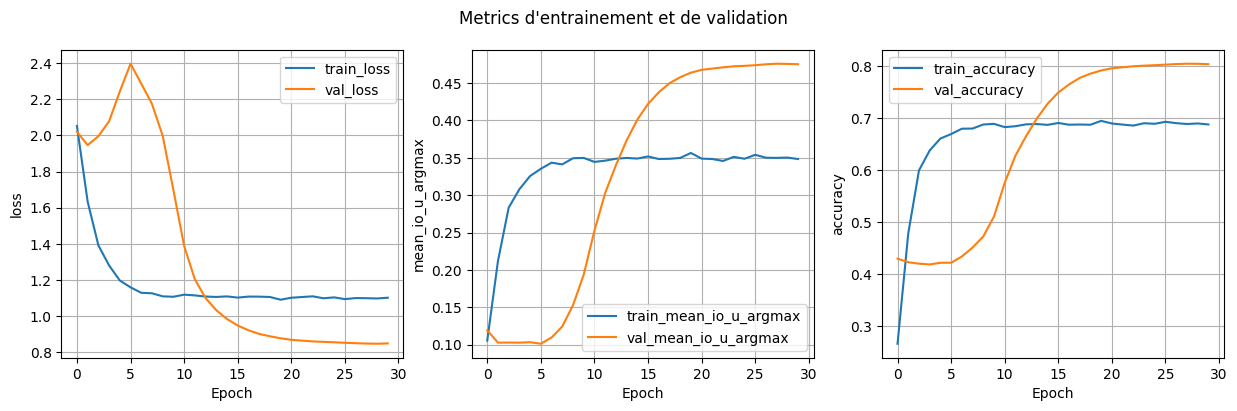

In [19]:
plot_training_history(history=hist_mini_unet, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3)

Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


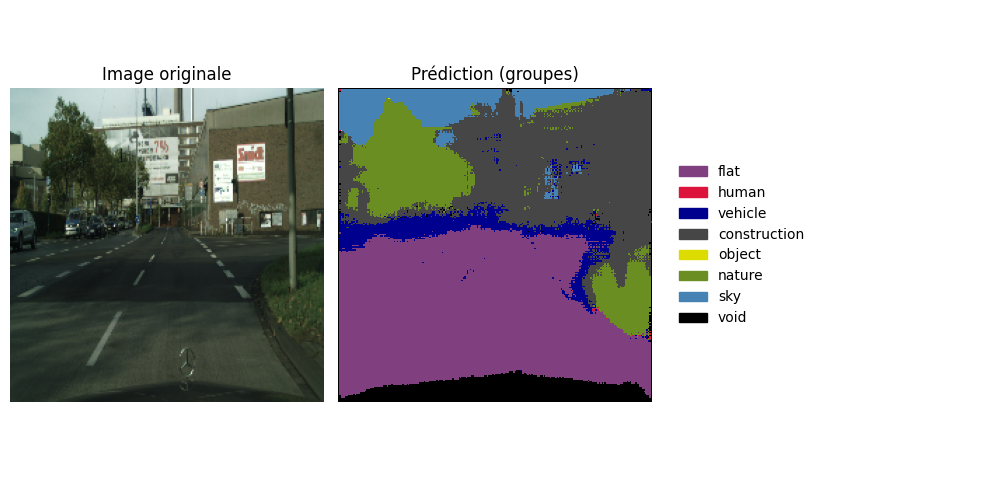

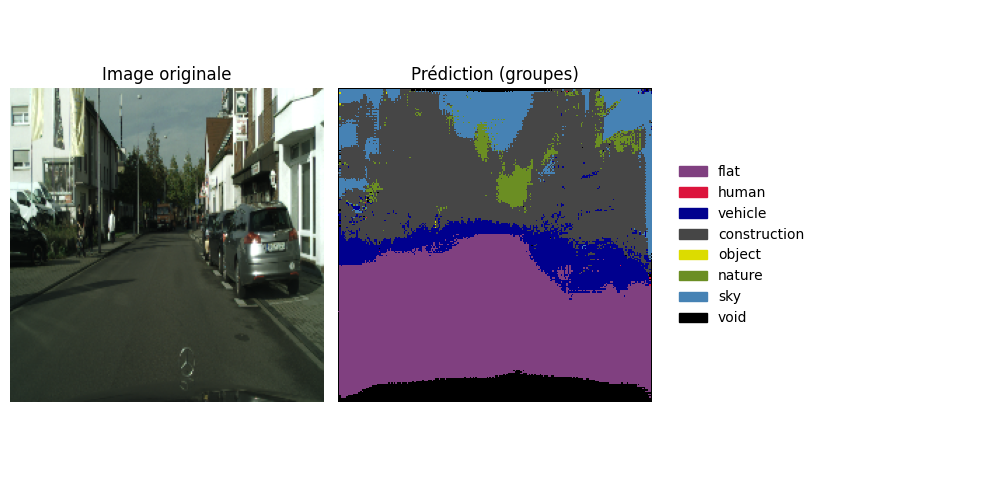

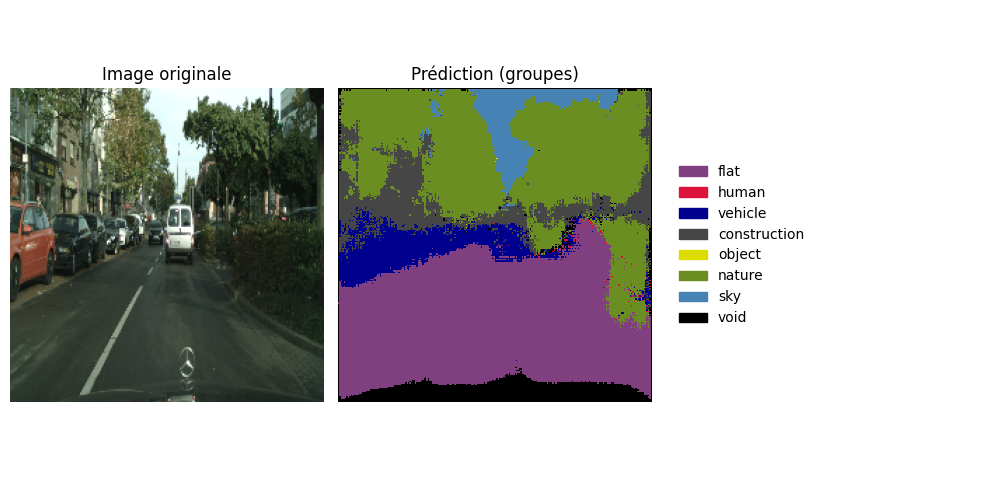

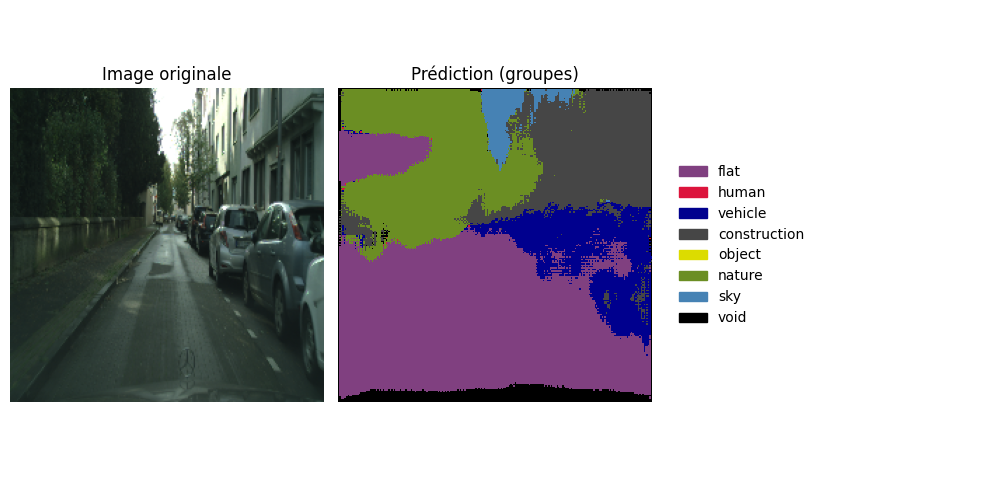

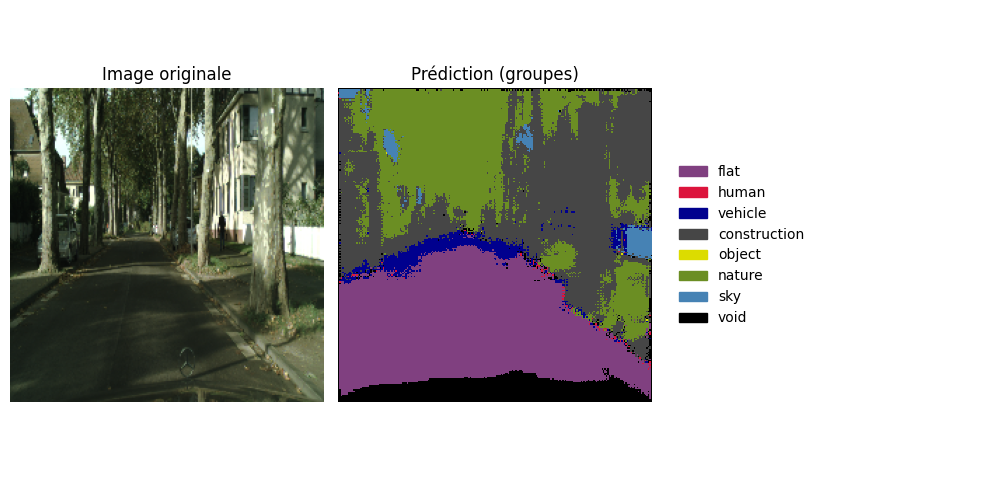

In [20]:
for batch, masks in test_ds.take(1):  # prendre un seul batch (32 images)
    preds = mini_unet_model.predict(batch)  # prédictions sur les 32 images
    masks = np.argmax(preds, axis=-1)  # (32, H, W)
    batch_np = batch.numpy()  # convertir les images pour affichage

    for i in range(5):  # afficher les 5 premières
        display_prediction(batch_np[i], masks[i])

In [ ]:
%%time
mlflow.set_experiment("mini_unet_model")

for x_batch, _ in test_ds.take(1):
    x_example = x_batch.numpy()
    break

with mlflow.start_run():
    mlflow.log_param("loss_type", "sparse_categorical_crossentropy")
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("epochs", epochs)

    mlflow.log_metric("mean_val_accuracy", np.mean(hist_mini_unet.history["val_accuracy"]))
    mlflow.log_metric("mean_val_loss", np.mean(hist_mini_unet.history["val_loss"]))
    mlflow.log_metric("val_mean_io_u_argmax", np.mean(hist_mini_unet.history["val_mean_io_u_argmax"]))

    signature = infer_signature(x_example, final_model.predict(x_example))

    mlflow.tensorflow.ar(
        model=final_model,
        signature=signature,
        artifact_path="model-artifact",
        registered_model_name="vgg16_unet_model"
    )

## VGG16-UNet

In [ ]:
vgg_model = create_model(model_type='vgg16_unet')
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "VGG16_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 41,077,384 (156.70 MB)

 Trainable params: 41,069,448 (156.67 MB)

 Non-trainable params: 7,936 (31.00 KB)

Compile et entrainement

In [ ]:
%%time
vgg_model = compile_model(vgg_model)
epochs = 30
train_sample = train_ds.take(int(0.4*len(train_ds)))
validation_sample = validation_ds.take(int(0.4*len(validation_ds)))
hist_vgg = vgg_model.fit(
    train_sample,
    validation_data=validation_sample,
    epochs=epochs,
    callbacks=cb
)

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.3390 - loss: 1.9055 - mean_io_u_argmax: 0.1293 - val_accuracy: 0.2106 - val_loss: 3.2863 - val_mean_io_u_argmax: 0.0539 - learning_rate: 1.0000e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 741ms/step - accuracy: 0.6515 - loss: 1.0649 - mean_io_u_argmax: 0.3034 - val_accuracy: 0.4447 - val_loss: 1.3678 - val_mean_io_u_argmax: 0.1761 - learning_rate: 1.0000e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 737ms/step - accuracy: 0.6993 - loss: 0.9351 - mean_io_u_argmax: 0.3519 - val_accuracy: 0.6371 - val_loss: 0.9661 - val_mean_io_u_argmax: 0.2918 - learning_rate: 1.0000e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 736ms/step - accuracy: 0.7157 - loss: 0.8828 - mean_io_u_argmax: 0.3687 - val_accuracy: 0.7116 - val_loss: 1.0141 - val_mean_io_u_argmax: 0.3701 - learning_rate: 1.0000e-04
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 739ms/step - accuracy: 0.7225 - loss: 0.8626 - mean_io_u_argmax: 0.3751 - val_accuracy: 0.7548 - val

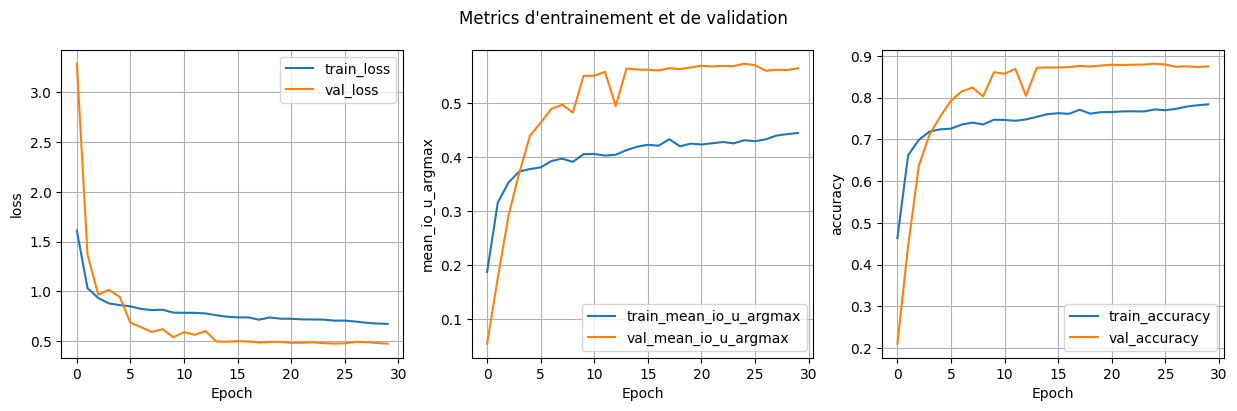

In [ ]:
plot_training_history(history=hist_vgg, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


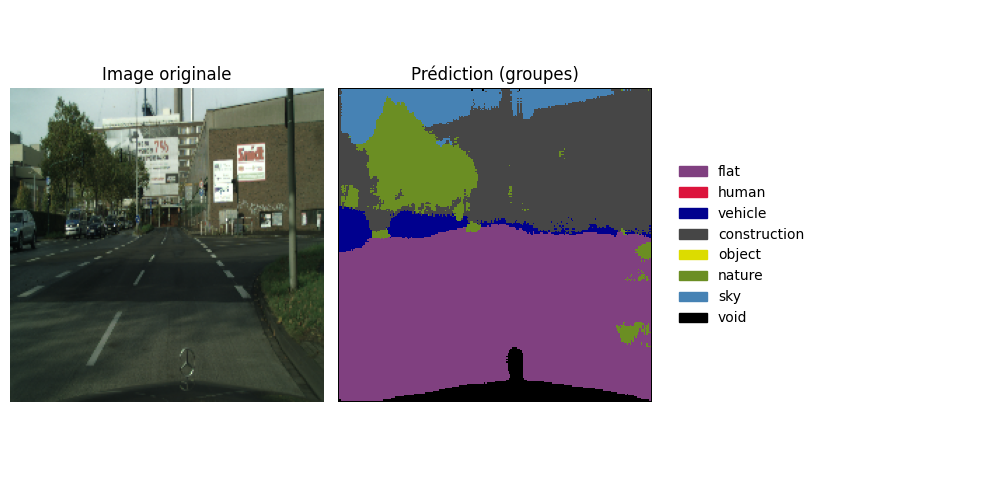

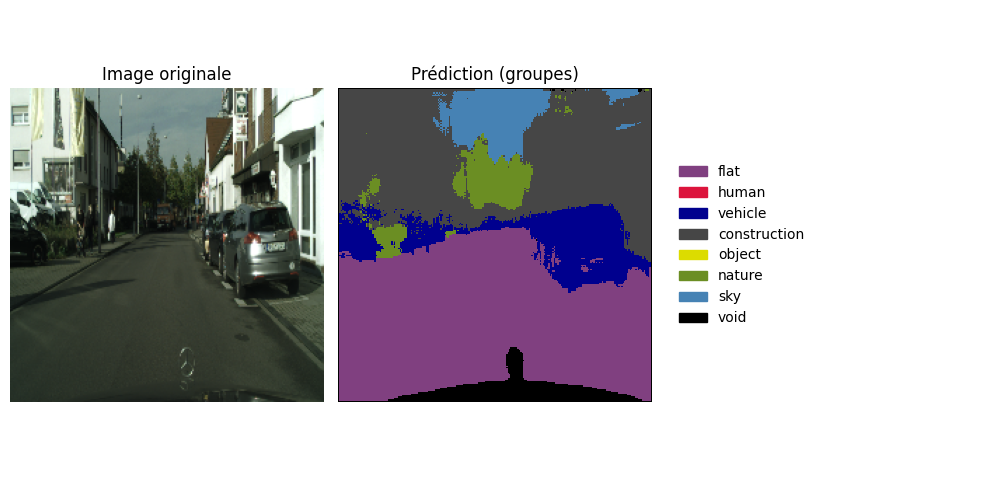

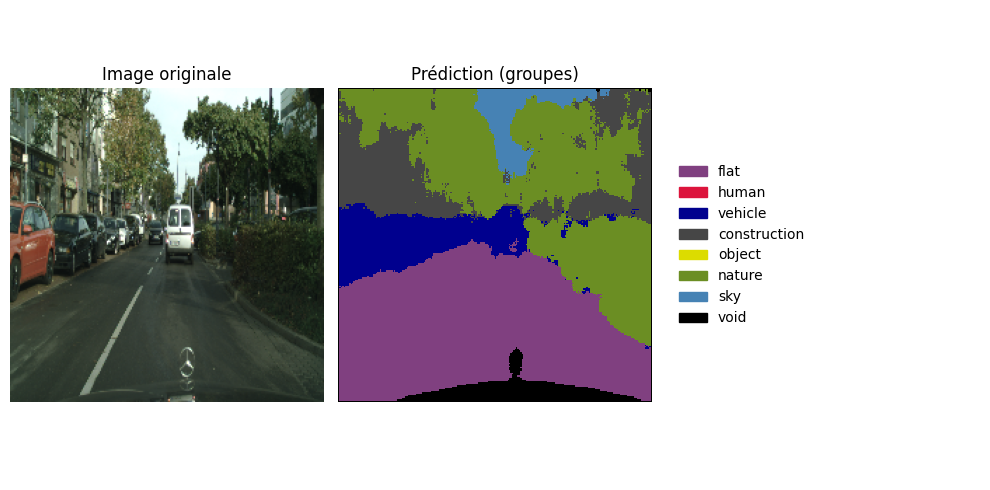

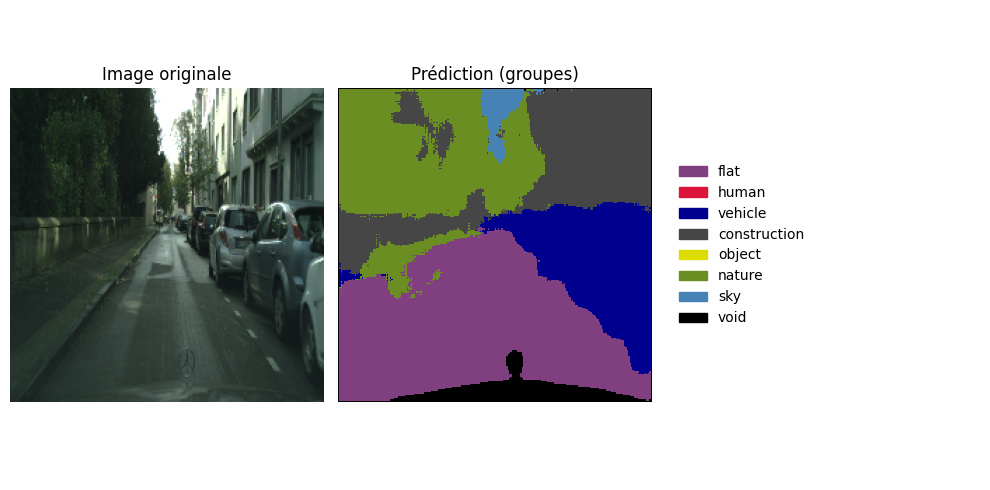

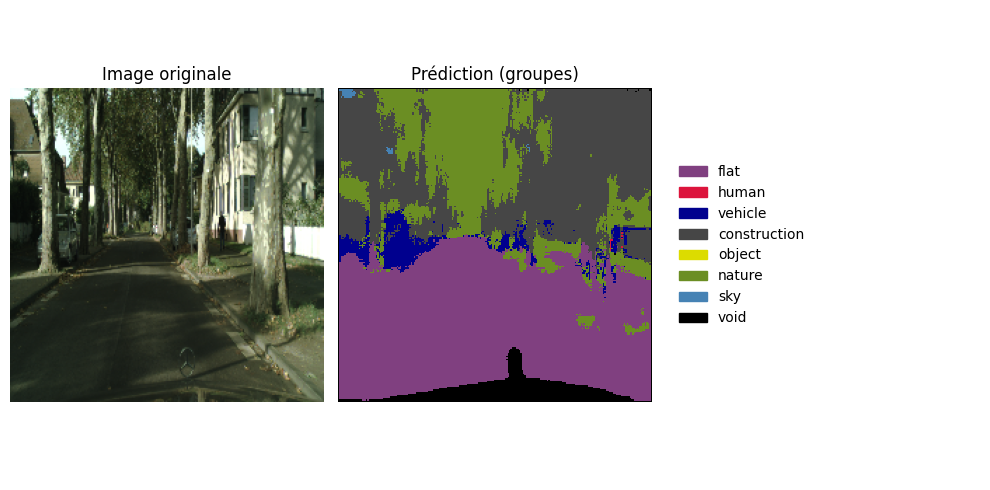

In [ ]:
for batch, masks in test_ds.take(1):  # prendre un seul batch (32 images)
    preds = vgg_model.predict(batch)  # prédictions sur les 32 images
    masks = np.argmax(preds, axis=-1)  # (32, H, W)
    batch_np = batch.numpy()  # convertir les images pour affichage

    for i in range(5):  # afficher les 5 premières
        display_prediction(batch_np[i], masks[i])

# Comparaison des modéls

## Performance

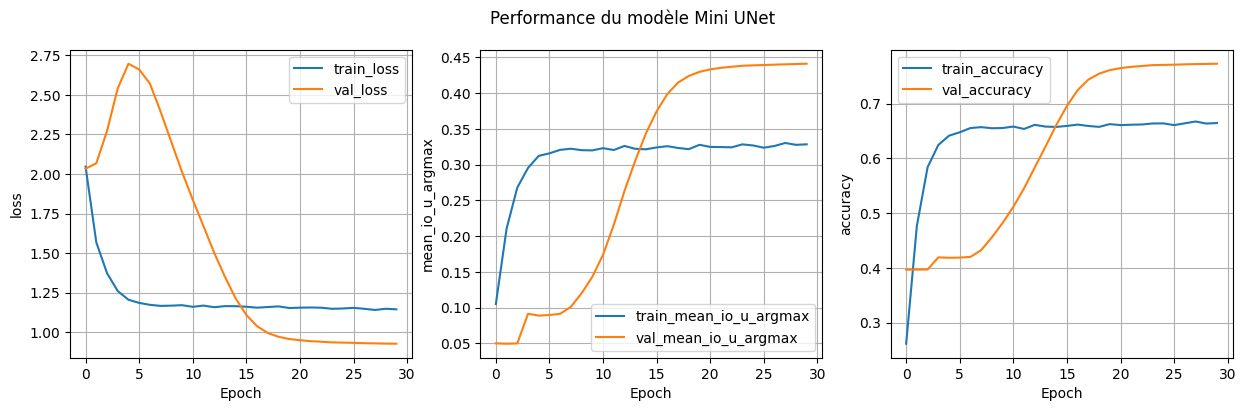

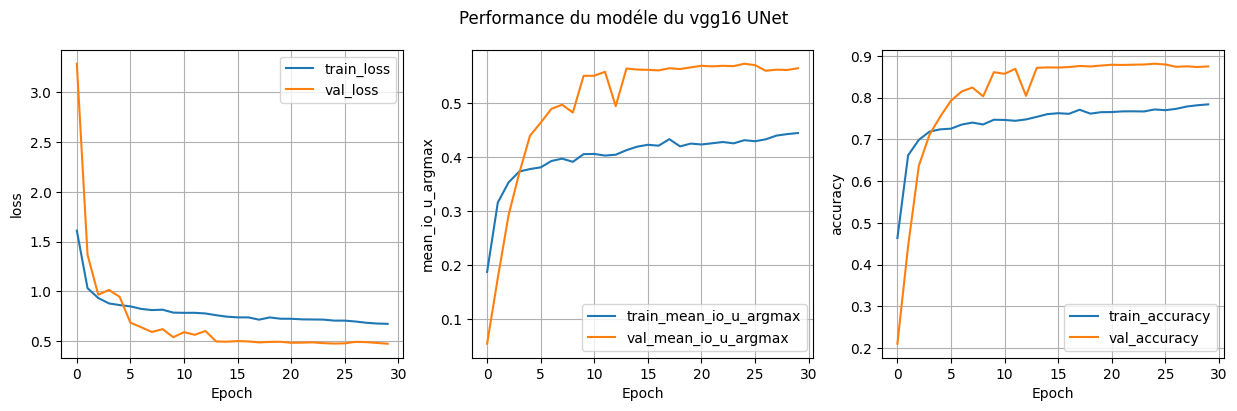

In [ ]:
plot_training_history(history=hist_mini_unet, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3, title="Performance du modèle Mini UNet")
plot_training_history(history=hist_vgg, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3, title="Performance du modéle du vgg16 UNet")

In [ ]:
import pandas as pd

df = pd.DataFrame({
    "Modèle": [
        "mini-U-Net",
        "VGG16-U-Net"
    ],
    "Val Loss final": [
        np.mean(hist_mini_unet.history['val_loss']),
        np.mean(hist_vgg.history['val_loss'])
    ],
    "Val Mean IoU (#8 classes)": [
        np.mean(hist_mini_unet.history['val_mean_io_u_argmax']),
        np.mean(hist_vgg.history['val_mean_io_u_argmax'])
    ],
    "Val Accuracy": [
        np.mean(hist_mini_unet.history['val_accuracy']),
        np.mean(hist_vgg.history['val_accuracy'])
    ],
    "Paramètres totaux": [
        mini_unet_model.count_params(),
        vgg_model.count_params()
    ],
    "Paramètres entraînables": [
        mini_unet_model.count_params(),
        vgg_model.count_params()
    ]
})

display(df)

Modèle  Val Loss final  Val Mean IoU (#8 classes)  Val Accuracy  \
0   mini-U-Net        1.515042                   0.286726      0.618035   
1  VGG16-U-Net        0.689969                   0.500546      0.809242   

   Paramètres totaux  Paramètres entraînables  
0            1931464                  1931464  
1           41077384                 41077384

**Loss de validation**
1.   Le VGG16-U-Net (0.69) réduit de plus de 50 % la loss par rapport au mini-U-Net (1.52).

2.   Un indicateur clair que ce backbone pré-entraîné apprend des représentations plus adaptées au jeu de Cityscapes.

**Mean IoU**
1.   Le VGG-U-Net atteint ≈ 0.50 contre ≈ 0.29 pour le mini-U-Net (+ 0.21 absolu, soit + 72 % relatif).

2.   C’est sur cette métrique clé de segmentation que l’écart est le plus marquant.

**Accuracy**
1.   Le VGG-U-Net frôle 0.81, tandis que le mini-U-Net plafonne à 0.62.
2.   Même si ce chiffre est pondéré par la dominance des classes majoritaires, la supériorité reste nette.

**Complexité du modèle**


1.   mini-U-Net : 1,93 M de paramètres, tous entraînables.
2.   VGG16-U-Net : 41,08 M de paramètres, tous entraînables.
3.   Le VGG-U-Net est ~ 21× plus volumineux, ce qui explique son coût mémoire et calcul supérieur.



## Conclusion

*   Le VGG16-U-Net offre une meilleure qualité de segmentation sur tous les indicateurs (loss, IoU, accuracy).


*   Le mini-U-Net est léger (≈ 2 M params) mais peine à généraliser (IoU < 0.30).

*   L’écart de performance se reflète directement dans la capacité à prédire correctement chaque classe pixel-par-pixel.

# Optimisation des hyperparametes

In [ ]:
!pip install optuna optuna-integration -q
import optuna
from optuna.integration import TFKerasPruningCallback

In [ ]:
train_sample = train_ds.take(int(0.4*len(train_ds)))
validation_sample = validation_ds.take(int(0.4*len(validation_ds)))

In [ ]:
def objective(trial):
    # Hyperparams à tuner
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    loss_type = trial.suggest_categorical("loss_type", ["cross_entropy", "dice_loss", "focal_loss", "balanced_cross_entropy"])


    model = create_model(model_type='vgg16_unet')
    model = compile_model(model, learning_rate=learning_rate, loss_type=loss_type)

    # Callback de pruning
    pruning_callback = TFKerasPruningCallback(trial, "val_accuracy")

    history = model.fit(
        train_sample,
        validation_data=validation_sample,
        epochs=30,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=3),
            pruning_callback
        ]
    )

    return max(history.history["val_accuracy"])

In [ ]:
%%time
study = optuna.create_study(study_name="vgg_unet_hyperparameter_optimization", direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-07-25 20:42:05,388] A new study created in memory with name: vgg_unet_hyperparameter_optimization


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 53s 847ms/step - accuracy: 0.4552 - loss: 0.3459 - mean_io_u_argmax: 0.1558 - val_accuracy: 0.2124 - val_loss: 0.3809 - val_mean_io_u_argmax: 0.0532 - learning_rate: 2.2691e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 742ms/step - accuracy: 0.6947 - loss: 0.2636 - mean_io_u_argmax: 0.3206 - val_accuracy: 0.6100 - val_loss: 0.2922 - val_mean_io_u_argmax: 0.2486 - learning_rate: 2.2691e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 735ms/step - accuracy: 0.7031 - loss: 0.2560 - mean_io_u_argmax: 0.3270 - val_accuracy: 0.6921 - val_loss: 0.2655 - val_mean_io_u_argmax: 0.3426 - learning_rate: 2.2691e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 733ms/step - accuracy: 0.7143 - loss: 0.2520 - mean_io_u_argmax: 0.3482 - val_accuracy: 0.6526 - val_loss: 0.2702 - val_mean_io_u_argmax: 0.3701 - learning_rate: 2.2691e-04
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 741ms/step - accuracy: 0.7295 - loss: 0.2471 - mean_io_u_argmax: 0.3812 - val_accuracy: 0.8326 - v

[I 2025-07-25 20:56:22,183] Trial 0 finished with value: 0.8901669979095459 and parameters: {'learning_rate': 0.00022690926587480133, 'loss_type': 'focal_loss'}. Best is trial 0 with value: 0.8901669979095459.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 852ms/step - accuracy: 0.5119 - loss: 0.8650 - mean_io_u_argmax: 0.2104 - val_accuracy: 0.0749 - val_loss: 0.9083 - val_mean_io_u_argmax: 0.0094 - learning_rate: 0.0039
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 735ms/step - accuracy: 0.6218 - loss: 0.8470 - mean_io_u_argmax: 0.2801 - val_accuracy: 0.5488 - val_loss: 0.8562 - val_mean_io_u_argmax: 0.2390 - learning_rate: 0.0039
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 725ms/step - accuracy: 0.6463 - loss: 0.8437 - mean_io_u_argmax: 0.2968 - val_accuracy: 0.2280 - val_loss: 0.8917 - val_mean_io_u_argmax: 0.0794 - learning_rate: 0.0039
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 720ms/step - accuracy: 0.6618 - loss: 0.8420 - mean_io_u_argmax: 0.3044 - val_accuracy: 0.2244 - val_loss: 0.8923 - val_mean_io_u_argmax: 0.0936 - learning_rate: 0.0039
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 724ms/step - accuracy: 0.6671 - loss: 0.8413 - mean_io_u_argmax: 0.3088 - val_accuracy: 0.3048 - val_loss: 0.8805 

[I 2025-07-25 21:09:29,997] Trial 1 finished with value: 0.8021845817565918 and parameters: {'learning_rate': 0.0039067333345803226, 'loss_type': 'dice_loss'}. Best is trial 0 with value: 0.8901669979095459.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 832ms/step - accuracy: 0.4554 - loss: 2.0569 - mean_io_u_argmax: 0.1629 - val_accuracy: 0.1871 - val_loss: 2.1707 - val_mean_io_u_argmax: 0.0237 - learning_rate: 0.0055
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 736ms/step - accuracy: 0.5244 - loss: 1.9276 - mean_io_u_argmax: 0.2089 - val_accuracy: 0.1557 - val_loss: 2.4159 - val_mean_io_u_argmax: 0.0827 - learning_rate: 0.0055
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 728ms/step - accuracy: 0.5268 - loss: 1.9197 - mean_io_u_argmax: 0.2118 - val_accuracy: 0.2417 - val_loss: 2.0888 - val_mean_io_u_argmax: 0.1200 - learning_rate: 0.0055
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 722ms/step - accuracy: 0.5475 - loss: 1.9105 - mean_io_u_argmax: 0.2218 - val_accuracy: 0.2243 - val_loss: 2.1748 - val_mean_io_u_argmax: 0.0881 - learning_rate: 0.0055
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 727ms/step - accuracy: 0.5679 - loss: 1.8973 - mean_io_u_argmax: 0.2369 - val_accuracy: 0.1900 - val_loss: 2.2203 

[I 2025-07-25 21:23:27,975] Trial 2 finished with value: 0.7665591835975647 and parameters: {'learning_rate': 0.005537558330307877, 'loss_type': 'balanced_cross_entropy'}. Best is trial 0 with value: 0.8901669979095459.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 847ms/step - accuracy: 0.2069 - loss: 2.2174 - mean_io_u_argmax: 0.0904 - val_accuracy: 0.1340 - val_loss: 4.0124 - val_mean_io_u_argmax: 0.0465 - learning_rate: 1.1727e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 745ms/step - accuracy: 0.6258 - loss: 1.2565 - mean_io_u_argmax: 0.2968 - val_accuracy: 0.2710 - val_loss: 1.6204 - val_mean_io_u_argmax: 0.1358 - learning_rate: 1.1727e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 733ms/step - accuracy: 0.6987 - loss: 1.0430 - mean_io_u_argmax: 0.3590 - val_accuracy: 0.6650 - val_loss: 1.0901 - val_mean_io_u_argmax: 0.3524 - learning_rate: 1.1727e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 730ms/step - accuracy: 0.7194 - loss: 0.9493 - mean_io_u_argmax: 0.3763 - val_accuracy: 0.5831 - val_loss: 1.5688 - val_mean_io_u_argmax: 0.3103 - learning_rate: 1.1727e-04
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 732ms/step - accuracy: 0.7325 - loss: 0.8896 - mean_io_u_argmax: 0.3911 - val_accuracy: 0.5141 - v

[I 2025-07-25 21:33:59,280] Trial 3 finished with value: 0.8610048890113831 and parameters: {'learning_rate': 0.00011726769859932383, 'loss_type': 'cross_entropy'}. Best is trial 0 with value: 0.8901669979095459.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 855ms/step - accuracy: 0.4111 - loss: 0.3501 - mean_io_u_argmax: 0.1499 - val_accuracy: 0.2928 - val_loss: 0.3657 - val_mean_io_u_argmax: 0.1018 - learning_rate: 2.7247e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 742ms/step - accuracy: 0.6972 - loss: 0.2635 - mean_io_u_argmax: 0.3171 - val_accuracy: 0.7254 - val_loss: 0.2442 - val_mean_io_u_argmax: 0.3098 - learning_rate: 2.7247e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 732ms/step - accuracy: 0.7028 - loss: 0.2570 - mean_io_u_argmax: 0.3289 - val_accuracy: 0.7378 - val_loss: 0.2455 - val_mean_io_u_argmax: 0.3706 - learning_rate: 2.7247e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 735ms/step - accuracy: 0.7136 - loss: 0.2531 - mean_io_u_argmax: 0.3467 - val_accuracy: 0.7935 - val_loss: 0.2272 - val_mean_io_u_argmax: 0.4305 - learning_rate: 2.7247e-04
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 738ms/step - accuracy: 0.7257 - loss: 0.2487 - mean_io_u_argmax: 0.3770 - val_accuracy: 0.7991 - v

[I 2025-07-25 21:48:11,518] Trial 4 finished with value: 0.8959381580352783 and parameters: {'learning_rate': 0.00027247382607673, 'loss_type': 'focal_loss'}. Best is trial 4 with value: 0.8959381580352783.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5184 - loss: 1.4271 - mean_io_u_argmax: 0.2137

[I 2025-07-25 21:49:01,236] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 49s 798ms/step - accuracy: 0.3972 - loss: 0.3652 - mean_io_u_argmax: 0.1398 - val_accuracy: 0.2185 - val_loss: 0.3821 - val_mean_io_u_argmax: 0.0630 - learning_rate: 1.1067e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.6529 - loss: 0.2836 - mean_io_u_argmax: 0.2827

[I 2025-07-25 21:50:18,893] Trial 6 pruned. Trial was pruned at epoch 1.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.4250 - loss: 0.8821 - mean_io_u_argmax: 0.1650

[I 2025-07-25 21:51:08,724] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.5173 - loss: 0.8658 - mean_io_u_argmax: 0.2386

[I 2025-07-25 21:51:58,750] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/30


[W 2025-07-25 21:52:32,039] Trial 9 failed with parameters: {'learning_rate': 0.003947274998222706, 'loss_type': 'combined_loss'} because of the following error: ResourceExhaustedError().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-73-3842946298.py", line 13, in objective
    history = model.fit(
              ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/execute.py", line 59, in quick_execute
    except TypeError as e:
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", l

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-76-1911207080.py", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/google/colab/_shell.py", line 276, in run_cell_magic

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2473, in run_cell_magic

  File "<decorator-gen-54>", line 2, in time

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/magic.py", line 187, in <lambda>

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/magics/execution.py", line 1340, in time

  File "<timed exec>", line 2, in <module>

  File "/usr/local/lib/python3.11/dist-packages/optuna/study/study.py", line 489, in optimize

  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 64, in _optimize

  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 161, in _optimize_sequential

  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial

  File "/tmp/ipython-input-73-3842946298.py", line 13, in objective

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 9052319176 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_615580]

In [ ]:
print("Best hyperparameters:")
print(study.best_params)

print("Best validation accuracy:", study.best_value)

Best hyperparameters:
{'learning_rate': 0.00027247382607673, 'loss_type': 'focal_loss'}
Best validation accuracy: 0.8959381580352783


In [ ]:
optuna.visualization.plot_slice(study,target_name="Accuracy")

In [ ]:
optuna.visualization.plot_rank(study)

Entrainement du modéle final

In [ ]:
final_model = create_model(model_type='vgg16_unet')
final_model = compile_model(
    final_model,
    learning_rate=study.best_params["learning_rate"],
    loss_type=study.best_params["loss_type"],
    metrics=['accuracy', MeanIoUArgmax(num_classes=8)]
)
final_model.summary()

Model: "VGG16_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_28[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 41,077,384 (156.70 MB)

 Trainable params: 41,069,448 (156.67 MB)

 Non-trainable params: 7,936 (31.00 KB)

In [ ]:
history = final_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3),
    ]
)

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - accuracy: 0.5564 - loss: 0.3105 - mean_io_u_argmax: 0.2254 - val_accuracy: 0.6303 - val_loss: 0.2859 - val_mean_io_u_argmax: 0.2503 - learning_rate: 2.7247e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 731ms/step - accuracy: 0.7236 - loss: 0.2493 - mean_io_u_argmax: 0.3701 - val_accuracy: 0.6192 - val_loss: 0.2789 - val_mean_io_u_argmax: 0.3126 - learning_rate: 2.7247e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 731ms/step - accuracy: 0.7376 - loss: 0.2435 - mean_io_u_argmax: 0.3892 - val_accuracy: 0.6777 - val_loss: 0.2612 - val_mean_io_u_argmax: 0.3362 - learning_rate: 2.7247e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 730ms/step - accuracy: 0.7468 - loss: 0.2401 - mean_io_u_argmax: 0.4014 - val_accuracy: 0.7164 - val_loss: 0.2484 - val_mean_io_u_argmax: 0.3862 - learning_rate: 2.7247e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 68s 729ms/step - accuracy: 0.7425 - loss: 0.2410 - mean_io_u_argmax: 0.3955 - val_accuracy: 0.7998 - val

Visualisation des performances

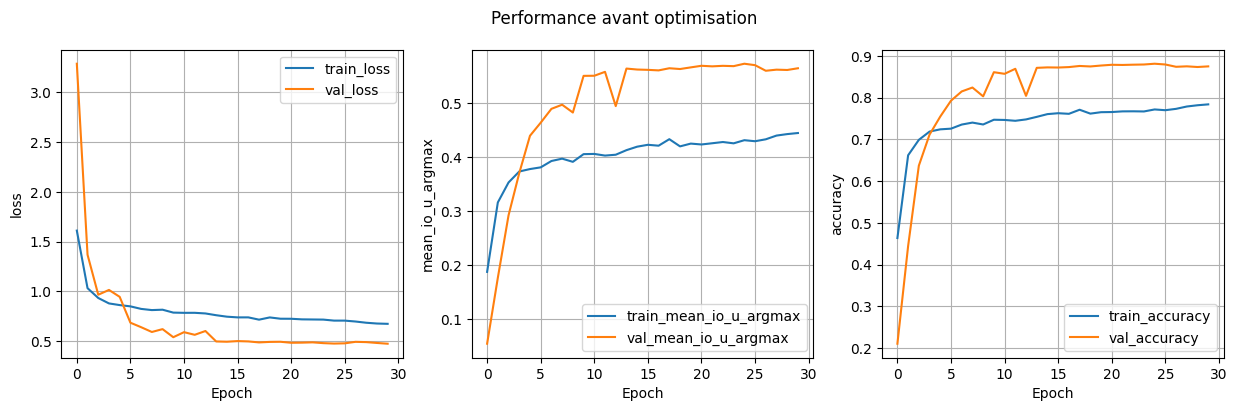

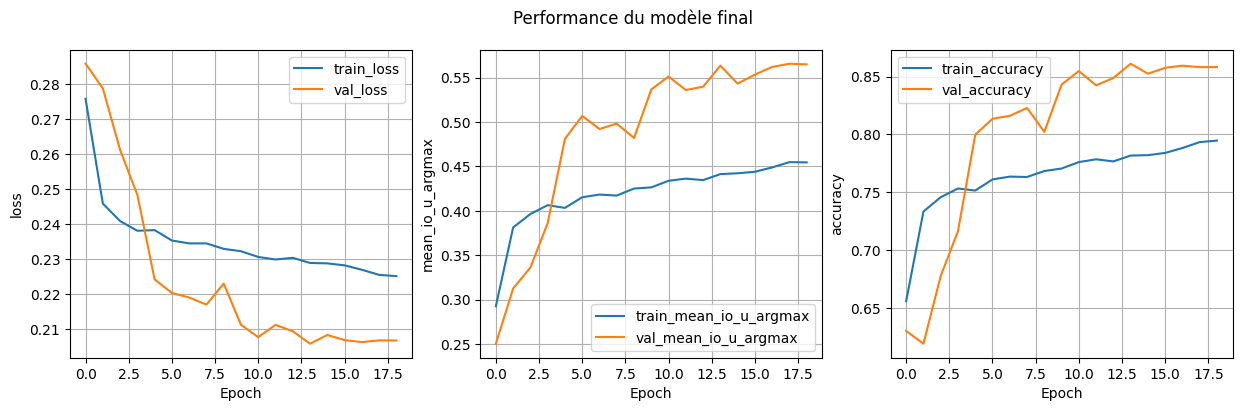

In [ ]:
plot_training_history(history=hist_vgg, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3, title="Performance avant optimisation")
plot_training_history(history=history, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3, title="Performance du modèle final")

Tests de prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


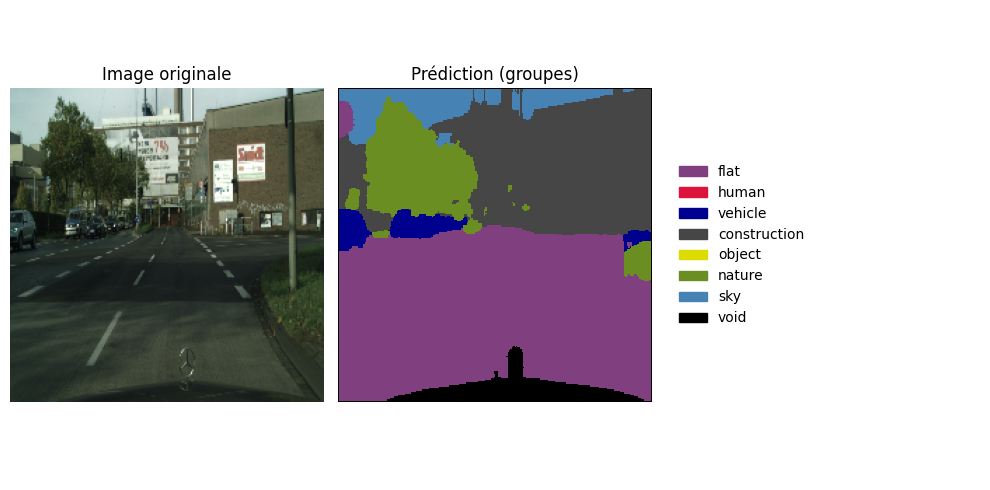

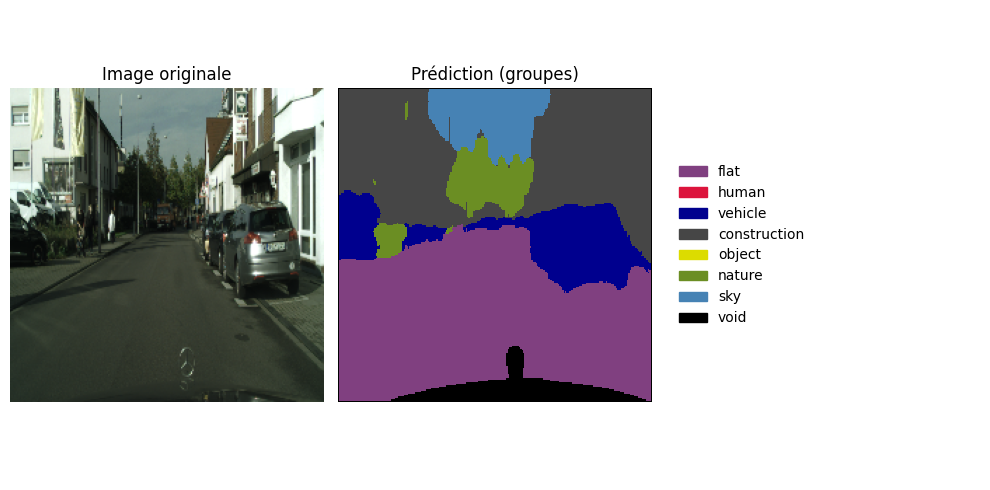

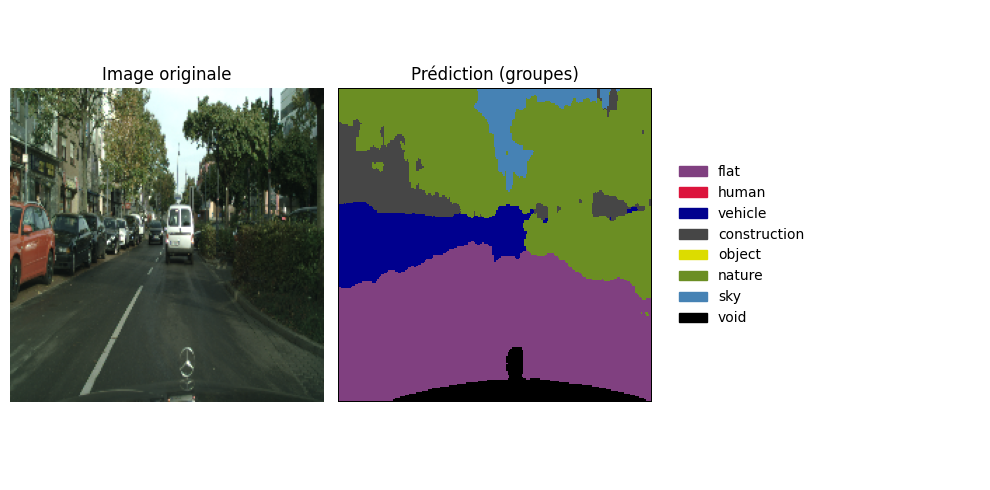

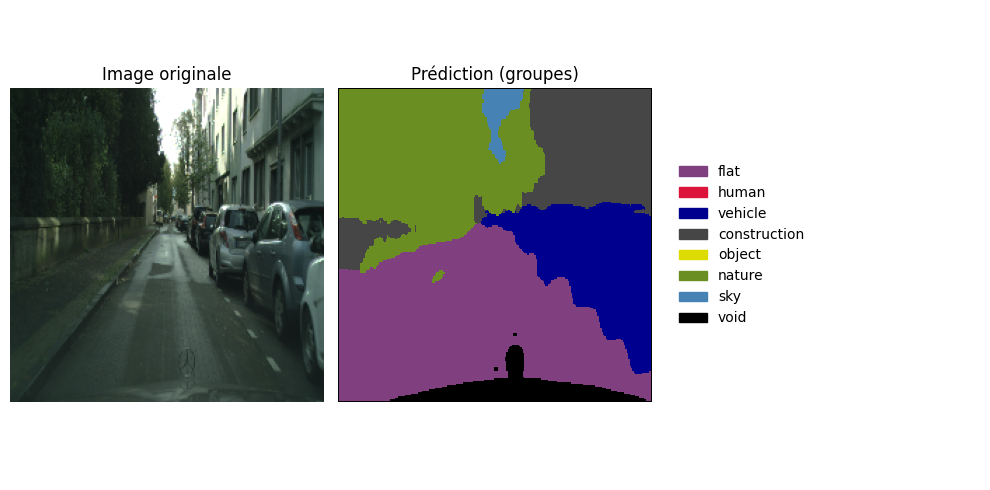

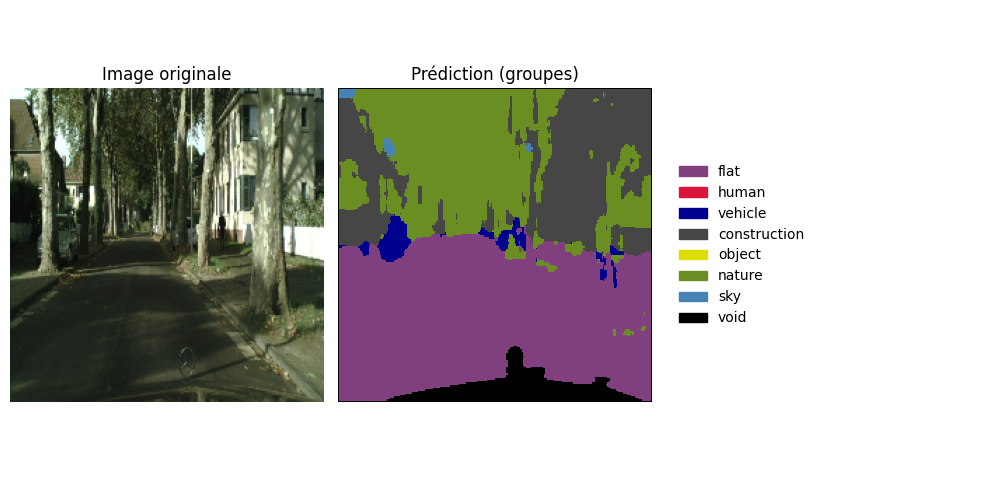

In [ ]:
for batch, masks in test_ds.take(1):  # prendre un seul batch (32 images)
    preds = final_model.predict(batch)  # prédictions sur les 32 images
    masks = np.argmax(preds, axis=-1)  # (32, H, W)
    batch_np = batch.numpy()  # convertir les images pour affichage

    for i in range(5):  # afficher les 5 premières
        display_prediction(batch_np[i], masks[i])

In [ ]:
# MLFLOW
!pip install mlflow==2.22.0 -q
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 127.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.0/677.0 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.2 MB/s eta 0:00:00


In [ ]:
%%time
MLFLOW_TRACKING_URI = "https://mlflow.amadousy.dev"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("vgg16_unet_model")

for x_batch, _ in test_ds.take(1):
    x_example = x_batch.numpy()
    break

with mlflow.start_run():
    mlflow.log_param("learning_rate", study.best_params["learning_rate"])
    mlflow.log_param("loss_type", study.best_params["loss_type"])
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("epochs", 30)

    mlflow.log_metric("mean_val_accuracy", np.mean(history.history["val_accuracy"]))
    mlflow.log_metric("mean_val_loss", np.mean(history.history["val_loss"]))
    mlflow.log_metric("val_mean_io_u_argmax", np.mean(history.history["val_mean_io_u_argmax"]))

    signature = infer_signature(x_example, final_model.predict(x_example))

    mlflow.tensorflow.log_model(
        model=final_model,
        signature=signature,
        artifact_path="model-artifact",
        registered_model_name="vgg16_unet_model"
    )


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


2025/07/25 23:24:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpsrv_5mpf/model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
Registered model 'vgg16_unet_model' already exists. Creating a new version of this model...
2025/07/25 23:25:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: vgg16_unet_model, version 2
Created version '2' of model 'vgg16_unet_model'.


🏃 View run sassy-rat-13 at: https://mlflow.amadousy.dev/#/experiments/20/runs/95f756470660473583e73e86d92ba202
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/20
CPU times: user 6.19 s, sys: 1.41 s, total: 7.6 s
Wall time: 1min 12s


In [ ]:
end_time = time.time()
print(f"Execution time={end_time-init_time} seconds")

Execution time=1702.4495713710785 seconds
